https://habr.com/ru/articles/479178/

fee_V4 = 81341.4537626213 + 386323.710952989 * V4,
total_out_value_V3 = 2742460603.92287 + 15853961614.9796 * V3.

inputs_count_V6 = 13.3266685112665 * V6 + 2.62544842444139,
inputs_unique_count_V8 = 11.9243179897452 * V8 + 2.34747189219164,
outputs_count_V7 = 50.3777694891647 * V7 + 4.21030186142152,
outputs_unique_count_V16 = 49.3957564403755 * V16 + 4.121809499973.


Even if we are able to figure out the math behind the transformations, we wouldn't know what is the meaning of the variable itself, like if i see the numbers 5,4,2,6,7,9, how am i to know what these values mean? 

Don't actually need the labels of the columns to train a model, we just need to give them names, and let the model pick out which features are the useful ones. Human-readable names are just for us to understand, the computer doesnt need it. 

We also don't actually need to predict all classes accurately, just illicit class because in fraud, it is ok to have false positives. The trade-off we can go for is that its better to pick up more correct ones with some false positives, than to pick up less correct ones with no false positives. False positive better than false negative because false negative means u missed the fraud. 

The real goal here is just to accurately detect class 1. 

This person managed to find the transaction numbers, but semantically it has the same use as txID so idk what it can be used for:
https://www.kaggle.com/datasets/alexbenzik/deanonymized-995-pct-of-elliptic-transactions/data

We can create features without semantics:

group by time step, or user's wallet
u can find difference, tx counts

PCA and correlation to detect redundant features, pick features based on variance

KMeans for clusters

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
# Load data
class_df = pd.read_csv("elliptic_txs_classes.csv")
edge_df = pd.read_csv(r"elliptic_txs_edgelist.csv")
feature_df = pd.read_csv(r"elliptic_txs_features.csv", header=None)

# Copied from Kaggle
colnames1 = {'0': 'txId', 1: "time_step"}
colnames2 = {str(ii+2): "local_feature_" + str(ii+1) for ii in range(93)}
colnames3 = {str(ii+95): "aggregate_feature_" + str(ii+1) for ii in range(72)}

colnames = dict(colnames1, **colnames2, **colnames3 )
colnames = {int(jj): item_kk for jj,item_kk in colnames.items()}
feature_df = feature_df.rename(columns=colnames)

In [5]:
print(feature_df.columns)


Index(['txId', 'time_step', 'local_feature_1', 'local_feature_2',
       'local_feature_3', 'local_feature_4', 'local_feature_5',
       'local_feature_6', 'local_feature_7', 'local_feature_8',
       ...
       'aggregate_feature_63', 'aggregate_feature_64', 'aggregate_feature_65',
       'aggregate_feature_66', 'aggregate_feature_67', 'aggregate_feature_68',
       'aggregate_feature_69', 'aggregate_feature_70', 'aggregate_feature_71',
       'aggregate_feature_72'],
      dtype='object', length=167)


In [7]:
# find out if its sequential: ITS NOT SEQUENTIAL

# Use only the first 100 rows of feature_df
feature_df_small = feature_df.head(100)

# Extract the txid list from that smaller dataset
txid_list = feature_df_small['txId'].tolist()

# Function to check sequential order
def is_sequential(txid1, txid2, txid_list):
    try:
        idx1 = txid_list.index(txid1)
        idx2 = txid_list.index(txid2)
        return idx1 + 1 == idx2
    except ValueError:
        return False  # If either ID is not found

# Apply the function to edge_df
edge_df['sequential'] = edge_df.apply(lambda row: is_sequential(row['txId'], row['txId2'], txid_list), axis=1)

# Show results
print(edge_df[['txId', 'txId2', 'sequential']])



             txId      txId2  sequential
0       230425980    5530458        True
1       232022460  232438397        True
2       230460314  230459870        True
3       230333930  230595899        True
4       232013274  232029206        True
...           ...        ...         ...
234350  158365409  157930723       False
234351  188708874  188708879       False
234352  157659064  157659046       False
234353   87414554  106877725       False
234354  158589452  158589457       False

[234355 rows x 3 columns]


In [ ]:
# Do new aggregation for mean (but then why mean)

# Step 1: Drop all aggregate feature columns
cols_to_drop = [col for col in feature_df.columns if 'aggregate_feature' in col]
feature_df = feature_df.drop(columns=cols_to_drop)

# Step 2: Identify local features (assuming they start with "local_feature_")
local_features = [col for col in feature_df.columns if col.startswith("local_feature_")]

# Step 3: Aggregate features per time step
# We'll compute the mean for each local feature grouped by 'Time step'
aggregate_features = feature_df.groupby('time_step')[local_features].mean().reset_index()

# Step 4: Rename the columns to 'aggregate_feature_X'
aggregate_features = aggregate_features.rename(
    columns={col: col.replace("local_feature", "new_aggregate_feature") for col in local_features}
)

# Step 5: Merge the new aggregate features back into the original feature_df
# Match on 'Time step'
feature_df = feature_df.merge(aggregate_features, on='time_step', how='left')
feature_df

In [6]:
# Change unknown class to 3, 2 is licit, 1 is illicit
class_df.loc[class_df['class'] == 'unknown', 'class'] = 3
print('Shape of classes', class_df.shape)
print('Shape of edges', edge_df.shape)
print('Shape of features', feature_df.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


         txId
class        
3      157205
1        4545
2       42019


,txId,class,time_step,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,...,aggregate_feature_63,aggregate_feature_64,aggregate_feature_65,aggregate_feature_66,aggregate_feature_67,aggregate_feature_68,aggregate_feature_69,aggregate_feature_70,aggregate_feature_71,aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


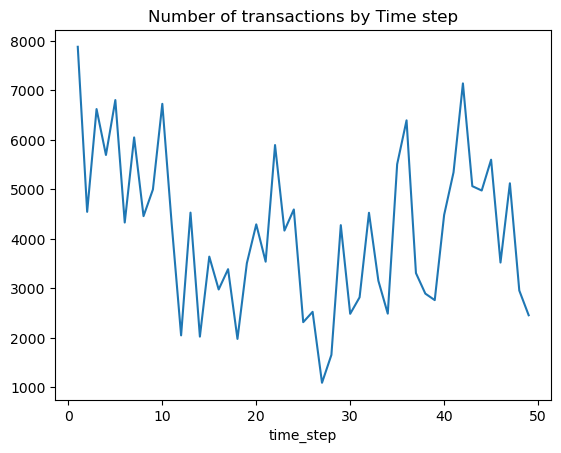

In [7]:
group_class = class_df.groupby('class').count()
print(group_class) # majority of transactions are from the unknown class

group_feature = feature_df.groupby('time_step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step') # one time step unit is 2 weeks, 49 steps in total

df_class_feature = pd.merge(class_df, feature_df )
df_class_feature.head()

Text(0.5, 0, 'time_step')

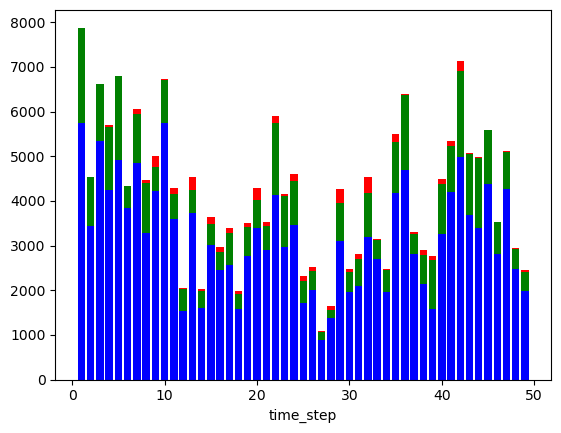

In [11]:
# Copied from kaggle, graph is same as the research paper
group_class_feature = df_class_feature.groupby(['time_step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 3 ]

p1 = plt.bar(class3['time_step'], class3['count'], color = 'b')

p2 = plt.bar(class2['time_step'], class2['count'], color='green',
             bottom=class3['count'])

p3 = plt.bar(class1['time_step'], class1['count'], color='red',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('time_step')

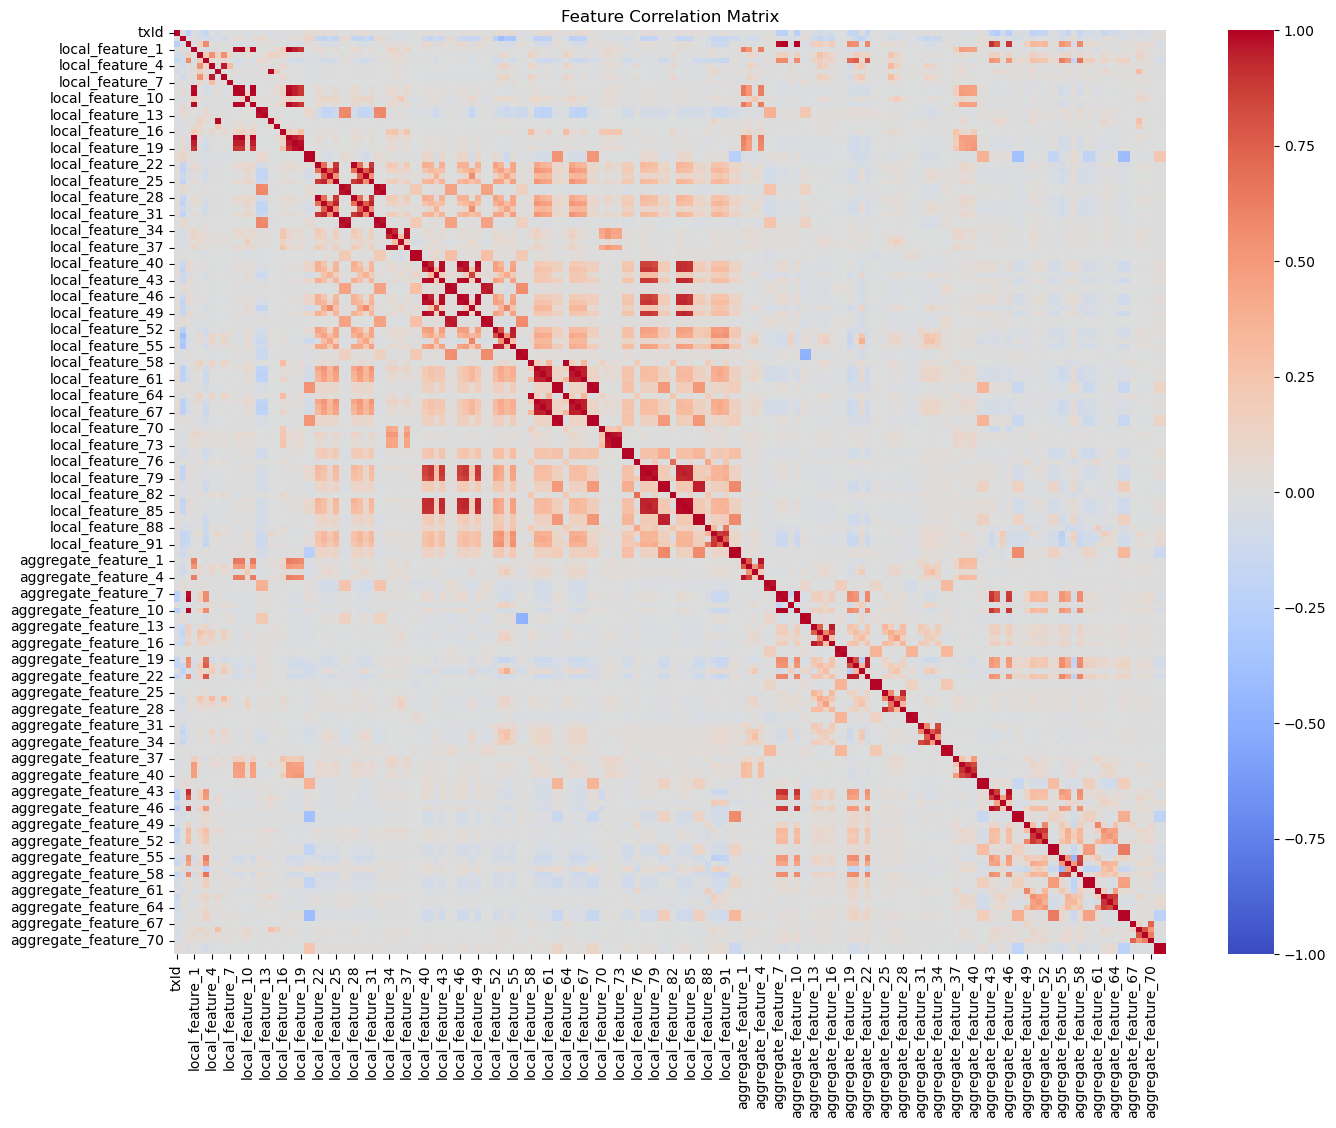

In [13]:
# Step 1: Compute correlation matrix
corr_matrix = df_class_feature.corr()

# Step 2: Plot heatmap of correlations
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

In [14]:
def get_high_corr_pairs(corr_matrix, threshold=0.8):
    corr_pairs = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    high_corr_pairs = corr_pairs.stack().reset_index()
    high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    return high_corr_pairs[abs(high_corr_pairs['Correlation']) >= threshold]

high_pairs = get_high_corr_pairs(corr_matrix, 0.8)
pd.set_option('display.max_rows', None)     # Display all rows
print(high_pairs)
pd.reset_option('display.max_rows')


                   Feature1              Feature2  Correlation
432               time_step   aggregate_feature_7     0.982430
433               time_step   aggregate_feature_8     0.994448
435               time_step  aggregate_feature_10     0.992579
468               time_step  aggregate_feature_43     0.911859
471               time_step  aggregate_feature_46     0.890583
504         local_feature_1       local_feature_8     0.977687
505         local_feature_1       local_feature_9     0.995457
507         local_feature_1      local_feature_11     0.983212
513         local_feature_1      local_feature_17     0.996121
514         local_feature_1      local_feature_18     0.945762
515         local_feature_1      local_feature_19     0.902021
988         local_feature_4       local_feature_6     0.957401
1156        local_feature_5      local_feature_14     0.990924
1625        local_feature_8       local_feature_9     0.985137
1627        local_feature_8      local_feature_11     0

In [15]:
df_class_feature = df_class_feature[df_class_feature['class'].isin(['1', '2'])]
X = df_class_feature.drop(columns=['txId', 'time_step', 'class'])
y = df_class_feature['class'].astype(int)

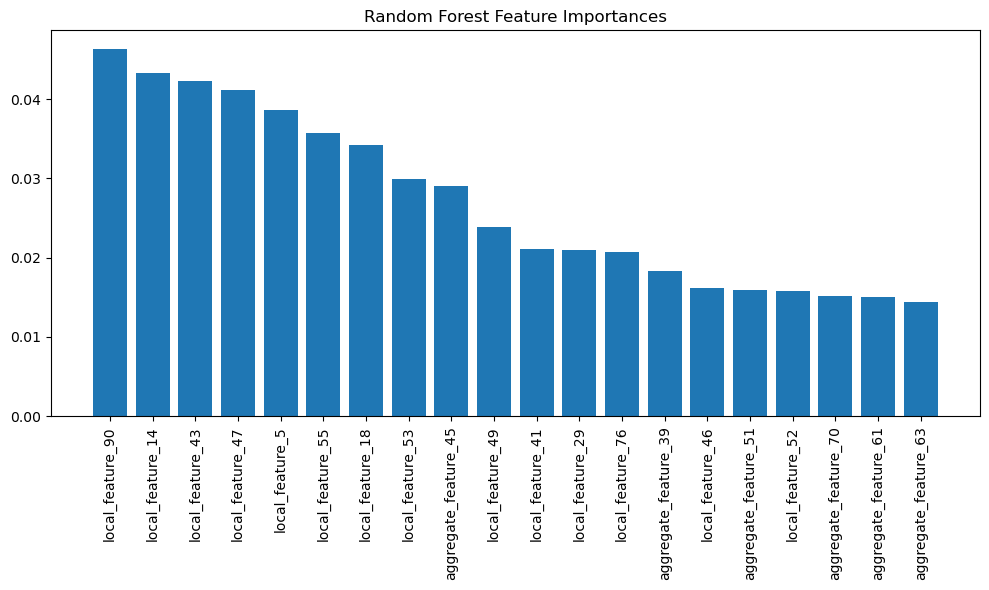

In [16]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot top 20 features
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()


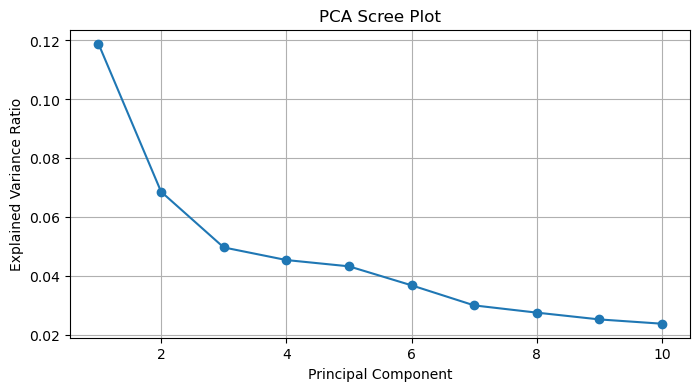

[0.11889789 0.18757298 0.23734509 0.2828325  0.32618691 0.36309109
 0.39318375 0.42082241 0.44615606 0.47003325]
Components needed for 95% variance: None
local_feature_90    0.165304
local_feature_89    0.164852
local_feature_91    0.162044
local_feature_55    0.161659
local_feature_83    0.159509
local_feature_84    0.157897
local_feature_85    0.155880
local_feature_77    0.152060
local_feature_59    0.151284
local_feature_65    0.151284
dtype: float64


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

if cumulative_variance[-1] < 0.95:
    print("Warning: Even 10 components do not explain 95% of variance.")
    n_components_95 = None
else:
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

loading_scores = pd.Series(pca.components_[0], index=X.columns)
top_features_PC1 = loading_scores.abs().sort_values(ascending=False).head(10)
print(top_features_PC1)


In [ ]:
# Model
# Use random forest for accuracy and logistic regression for explainability for the first 94 local features
# Then use the other 72 aggregate features to enhance?
# train on class 1 and 2, use the model to predict class 3?

# Merge them on the first column (assuming it's named 'id')
# If the first column has a different name, replace 'id' with the actual column name
merged = df1.merge(df2, on='txId', how='outer').merge(df3, on='txId', how='outer')

# Save the result
merged.to_csv('merged.csv', index=False)

# Load your merged CSV if you haven't already
merged = pd.read_csv('merged.csv')

# Create the new column as described
merged['has_missing'] = merged.isnull().any(axis=1).astype(int)

# Save the updated DataFrame
merged.to_csv('merged_with_missing_flag.csv', index=False)